# Tutorial: You can't put a label on me! Actually - please do.

## Creating optical water types from hyperspectral data --> OC-CCI (or any band combination)

Optical water type classification is a useful mechanism to isolate distinct reflectance signatures and track them over time and space. In another tutorial, we utilized the Apparent Visible Wavelength (AVW) to do something similar, but OWT classification uses a different approach, and tells us something a little different as well. Here, we are focusing more on using a priori knowledge of spectral reflectance, and using that as a reference point to find the closest match to the shape of our reflectance observed from satellites. The key advantage here is that we can put our data into a rigid and consistent classification system that clearly demarks areas with specific optical features. It's like being on a kitchy tour group and having everyone wear matching bright t-shirts so you can find one another... sort of. 

Our astute NOAA colleague Jianwei Wei, gatherred a large database of in situ and simualted hyperspectral refelctance data, and did some k-means clustering magic to come up with 23 distinct optical water classes. We're going to load those 23 distinct hyperspectral shapes, and then calculate the cosine distance between every spectra in our satellite image against all 23 of these shapes. The reflectance "shape" that produces the lowest cosine distance indicates 1 of those 23 shapes that is most similar to your satellite pixel. We assign each water class a different number and voila! - We have a mapped image putting our spectra into distinct optical water type classifications.  

Let's dive in and mess around with some spectra then. By the end of this tutorial, you will have:

> 1. Calculated the cosine distance between a spectral reference library against OC-CCI data
> 2. Assigned Optical Water Types (OWT) from OC-CCI data and made a map
> 3. Compared OC-CCI spectra against the reference OWT spectra

## *Are you ready?*

## Let's go get some data first

Going the ERDDAP route. Let's subset a region around U.S. side of the North Atlantic ocean.

In [5]:
# ---- Load Libraries ----
import numpy as np
import xarray as xr
import pandas as pd

# ---- Load Data ----
url = "https://comet.nefsc.noaa.gov/erddap/griddap/occci_V6_monthly_4km"
dataset = xr.open_dataset(url)

# Select a single time slice
dataset_sub = dataset.sel(time="2023-09-01")

# Define spatial subset
lat_bounds = slice(46, 35)  
lon_bounds = slice(-78, -63)  

# Subset the dataset (this keeps all bands intact)
rrs_subset = dataset_sub.sel(latitude=lat_bounds, longitude=lon_bounds)

# List of Rrs band variable names and matching wavelengths
bands = ['Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_510', 'Rrs_560', 'Rrs_665']
wavelengths = [412, 443, 490, 510, 560, 665]

# Stack the Rrs bands into a single DataArray with a new "band" dimension
rrs_array = xr.concat([rrs_subset[b] for b in bands], dim='band')
rrs_array = rrs_array.assign_coords(band=("band", wavelengths))

## Let's open it up!

Let's bring in our 23 reference spectra and match those to the OC-CCI wavelengths. Then make the cosine distance calculation to find the closest match.

In [6]:
# === Step 1: L2 normalize each pixel (Equation 1 in Wei et al. 2022) ===
norm = np.sqrt((rrs_array ** 2).sum(dim='band'))
rrs_norm = rrs_array / norm  # This gives unit-length spectra per pixel

# === Step 2: Load normalized reference spectra from CSV ===
# Assuming shape (23, 6) and wavelengths in same order as above
file_path = 'Hyperspectral_nRrs.csv'  # Replace with your actual CSV file path
wavelengths_str = [str(w) for w in wavelengths]
nRrs_ref = pd.read_csv(file_path, index_col=0)  # Optional: check structure
ref = nRrs_ref[wavelengths_str].values  # shape: (23, 6)
# === Match satellite normalization: same as (rrs_array ** 2).sum(dim='band')
squared = ref ** 2
norm = np.sqrt(squared.sum(axis=1, keepdims=True))  # shape (23, 1)
ref_normalized = ref / norm  # shape (23, bands)

# === Step 3: Flatten satellite data to (pixels, bands) for vector math ===
rrs_flat = rrs_norm.stack(pix=('latitude', 'longitude')).transpose('pix', 'band').values  # (pixels, 6)

# === Step 4: Compute cosine distance between each pixel and 23 references ===
dot_products = np.dot(rrs_flat, ref_normalized.T)  # (pixels, 23), since all are L2-normalized
cosine_distances = 1 - dot_products     # cosine distance = 1 - cosine similarity

# === Step 5: Assign water class with smallest distance (index + 1 for 1-based) ===
class_ids = np.argmin(cosine_distances, axis=1) + 1

# === Step 6: Reshape class_ids back into spatial map ===
lat_dim, lon_dim = rrs_subset.sizes['latitude'], rrs_subset.sizes['longitude']
class_map = xr.DataArray(
    class_ids.reshape(lat_dim, lon_dim),
    dims=('latitude', 'longitude'),
    coords={'latitude': rrs_subset['latitude'], 'longitude': rrs_subset['longitude']},
    name='water_class'
)

## Mappy time

Now, let's make a map of the optical water type for our single monthly image

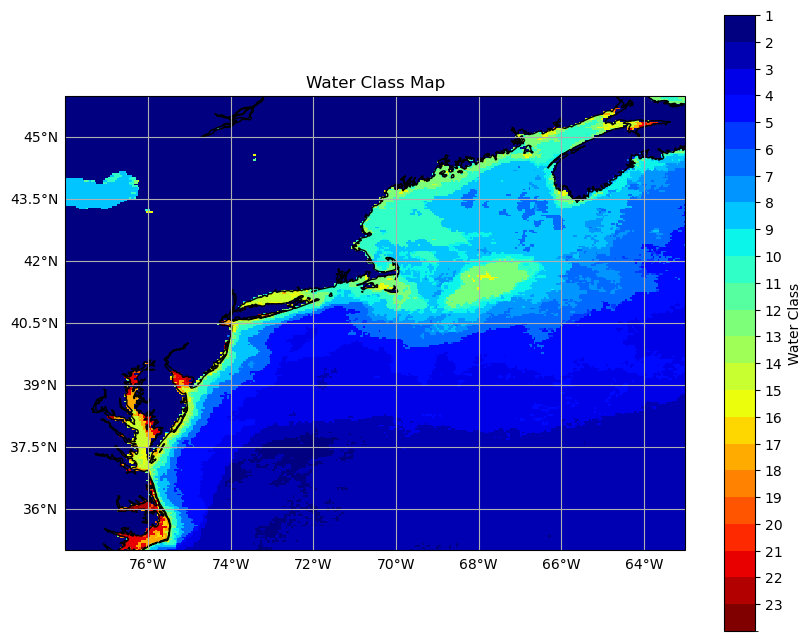

In [53]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Step 1: Plotting the class_map with matplotlib
plt.figure(figsize=(10, 8))

# If you want to use Cartopy for geographical projections
ax = plt.axes(projection=ccrs.PlateCarree())

# Define a colormap with 23 distinct colors (you can customize this list)
colors = plt.cm.jet(np.linspace(0, 1, 23))  # 23 colors from the 'viridis' colormap
cmap = ListedColormap(colors)

# Create a BoundaryNorm to discretize the colorbar and stretch it across all 23 classes
boundaries = np.arange(1, 25)  # 1 through 23, plus one extra boundary for the last class
norm = BoundaryNorm(boundaries, ncolors=23, clip=True)

# Plot the class_map with discretized colors
c = ax.pcolormesh(
    class_map.longitude, class_map.latitude, class_map,
    cmap=cmap, shading='auto', norm=norm
)

# Add coastlines for geographical context
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

# Add colorbar
cbar = plt.colorbar(c, ax=ax, label='Water Class')
cbar.set_ticks(np.arange(1, 24))  # Show ticks for whole numbers (1 through 23)
cbar.ax.invert_yaxis()  # Invert colorbar to match class order (if desired)

# Title and labels
plt.title('Water Class Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## But what does it all mean?

Here, we're going to take the mean + std of all spectra that fall within each specific class.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Reuse your class map color scheme
colors = plt.cm.jet(np.linspace(0, 1, 23))  # 23 class colors
cmap = ListedColormap(colors)
boundaries = np.arange(1, 25)
norm = BoundaryNorm(boundaries, ncolors=23, clip=True)

# === Compute mean spectra + std from satellite ===
rrs_flat = rrs_norm.stack(pix=('latitude', 'longitude')).transpose('pix', 'band')  # (pix, 6)
class_flat = class_map.stack(pix=('latitude', 'longitude'))  # (pix,)
mean_spectra = np.zeros((23, len(wavelengths)))  # (23, 6)
std_spectra = np.zeros((23, len(wavelengths)))  # (23, 6)

for class_id in range(1, 24):
    mask = (class_flat == class_id)
    if mask.sum() > 0:
        mean_spectra[class_id - 1] = rrs_flat.where(mask).mean(dim='pix').values
        std_spectra[class_id - 1] = rrs_flat.where(mask).std(dim='pix').values
    else:
        mean_spectra[class_id - 1] = np.nan
        std_spectra[class_id - 1] = np.nan


Finally, we're going to compare the mean satellite data spectral shapes against the reference library. This is a bit of a sanity check, but also allows you to get an idea of the variance within each class. 

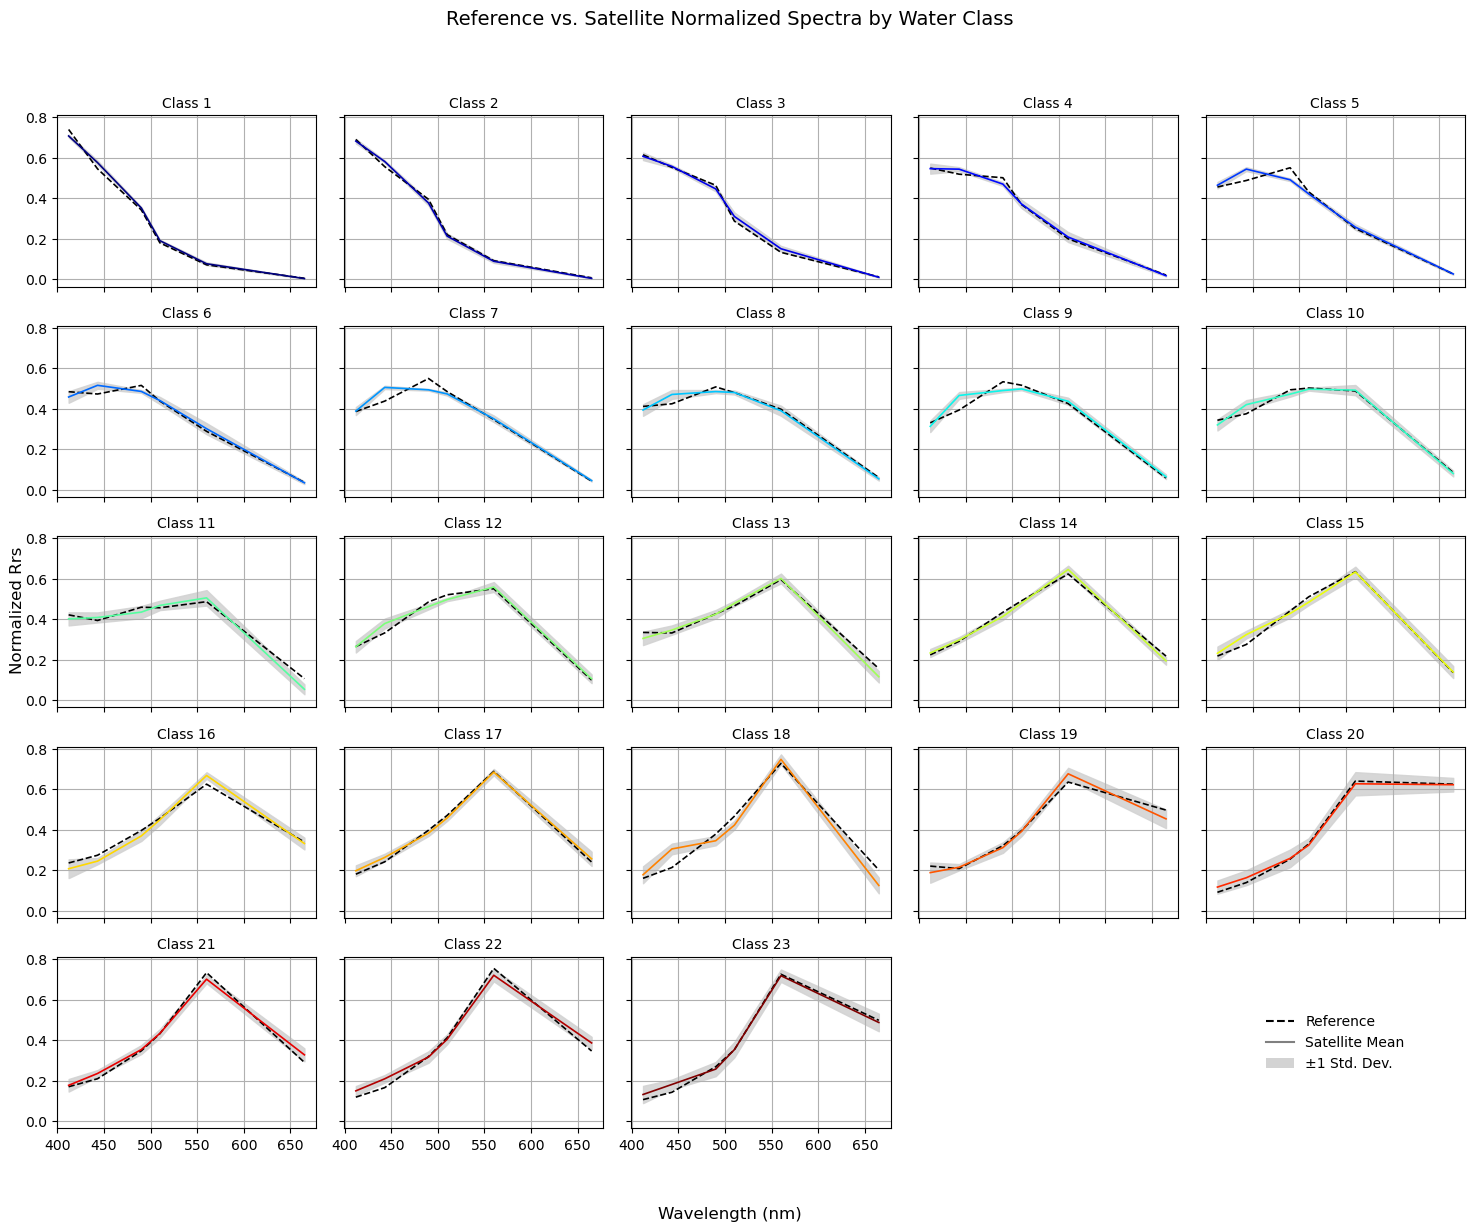

In [52]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Setup subplot grid
n_classes = 23
cols = 5
rows = int(np.ceil(n_classes / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting loop
for class_id in range(1, 24):
    ax = axes[class_id - 1]
    color = colors[class_id - 1]
    
    ref_spec = ref_normalized[class_id - 1]
    sat_spec = mean_spectra[class_id - 1]
    sat_std = std_spectra[class_id - 1]
    
    if not np.any(np.isnan(sat_spec)):
        ax.fill_between(
            wavelengths,
            sat_spec - sat_std,
            sat_spec + sat_std,
            color='lightgray',
            alpha=0.9,
            label='±1 Std. Dev.'
        )
        ax.plot(wavelengths, ref_spec, '--', color='black', linewidth=1.2, label='Reference')
        ax.plot(wavelengths, sat_spec, '-', color=color, linewidth=1.2, label='Satellite')

    ax.set_title(f'Class {class_id}', fontsize=10)
    ax.grid(True)
    ax.label_outer()

# Remove unused subplots and use one for legend
for i in range(n_classes, len(axes)):
    fig.delaxes(axes[i])

# Create a dummy legend in the bottom-right corner (last empty subplot position)
legend_ax = fig.add_subplot(rows, cols, cols * rows)  # last cell
legend_ax.axis('off')  # Hide axis

# Legend elements
legend_lines = [
    Line2D([0], [0], linestyle='--', color='black', label='Reference'),
    Line2D([0], [0], linestyle='-', color='gray', label='Satellite Mean'),
    Patch(facecolor='lightgray', edgecolor='none', label='±1 Std. Dev.')
]

legend_ax.legend(handles=legend_lines, loc='center', fontsize=10, frameon=False)

# Global labels
fig.suptitle("Reference vs. Satellite Normalized Spectra by Water Class", fontsize=14)
fig.supxlabel("Wavelength (nm)")
fig.supylabel("Normalized Rrs")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
